# ICESat-2 Bathymetry H5 File Reading Demo
This function reads ICESat-2 ALT03 h5 data as a DataFrame formatted similar to the dataframes produced by SlideRule ATL03 queries. Importantly, it upsamples several segment-rate parameters to the photon-rate for easier data analysis. It also returns parameters useful for bathymetric extraction, pulling fields like 'ref_azimuth' and 'ref_elevation' used in ICESat-2 bathymetric refraction.

Only works on data release 005+, as it requires the 'quality_ph' parameter.

__Jonathan Markel__<br />
Graduate Research Assistant <br />
[3D Geospatial Laboratory](https://magruder3dgl.com/icesat-2)<br />
The University of Texas at Austin <br />
jonathanmarkel@gmail.com

## Module Importing / Function Definition

In [14]:
import pandas as pd
import numpy as np
import geopandas as gpd
import h5py
import warnings
from ipyfilechooser import FileChooser
from astropy.time import Time
import re
import matplotlib.pyplot as plt

In [2]:
def convert_seg_to_ph_res(segment_res_data,
                          ph_index_beg,
                          segment_ph_cnt,
                          total_ph_cnt):

    '''Upsamples segment-rate data to the photon-rate.'''

    # initialize photon resolution array
    ph_res_data = pd.Series(np.nan, index=list(range(total_ph_cnt)))

    # trim away segments without photon data
    segs_with_data = segment_ph_cnt != 0

    segment_ph_cnt = segment_ph_cnt[segs_with_data]
    ph_index_beg = ph_index_beg[segs_with_data]
    segment_res_data = segment_res_data[segs_with_data]

    # set value for first photon in segment
    ph_res_data.iloc[ph_index_beg - 1] = segment_res_data
    ph_res_data.fillna(method='ffill', inplace=True)

    return ph_res_data.values

In [30]:
def read_h5_as_df(h5_path, gtxx, conf_type=1, verbose=False):
    
    if ((conf_type <= 0) or (conf_type >= 4)):
        raise Exception('''Requested confidence type must be between 
            0 and 4 (land, ocean, sea ice, land ice and inland water).''')
    
    # checks on beam input
    
    if isinstance(gtxx, str):
        # user input a single string like 'gt1r'
        
        # check its the right format
        gtxx = gtxx.lower()
        
        if re.search('gt[1-3][lr]', gtxx) is None:
            raise Exception('Unrecognized beam format. Use GT#(L/R) - for example, \'GT1R\'.')
        
        # set up in iterable
        gtxx = [gtxx]
        
        
    elif isinstance(gtxx, list):
        # user input a list of strings
        
        # make all inputs lowercase and remove duplicates
        
        gtxx = [g.lower() for g in gtxx]
        
        gtxx = list(np.unique(gtxx))
        
        # check all elements are the right format
        if any(re.search('gt[1-3][lr]', g) is None for g in gtxx):
            
            raise Exception('Unrecognized beam format. Use GT#(L/R) - for example, \'GT1R\'.')
        
        pass
    
    else:
        raise Exception('''Requested beams must be either a string (e.g.\'gt1r\')
                        or list (e.g. [\'gt1r\', \'gt2l\']).''')
        
    df_all = []
    if verbose:
        print(h5_file_path)
        print('File size: {:.2f} GB'.format(os.path.getsize(h5_file_path) / 1e9))
    
    with h5py.File(h5_file_path, 'r') as f:
        for beam in tqdm(gtxx):
            pho = dict()
            seg = dict()
            anc= {}
            
            if verbose: print(beam.upper())
            
            if verbose: print('Reading photon-resolution data...')
            ##### PHOTON RESOLUTION DATA #####

            lat_ph = np.array(f[beam + '/heights/lat_ph'])

            lon_ph = np.array(f[beam + '/heights/lon_ph'])

            pho['geometry'] = gpd.points_from_xy(lon_ph, lat_ph)

            pho['delta_time'] = np.array(f[beam + '/heights/delta_time'])

            pho['height'] = np.array(f[beam + '/heights/h_ph'])

            # sliderule documentation not clear on this - skipping
            #df['distance'] = np.array(f[gtxx + '/heights/dist_ph_along'])

            pho['quality_ph'] = np.array(f[beam + '/heights/quality_ph'])

            signal_conf = np.array(f[beam + '/heights/signal_conf_ph'])

            pho['atl03_cnf'] = signal_conf[:, conf_type] # user input signal type

            if verbose: print('Reading ancillary data...')
            ##### ANCILLARY / ORBIT DATA #####

            # variable resolution 

            anc['atlas_sdp_gps_epoch'] = np.array(
                f['/ancillary_data/atlas_sdp_gps_epoch'])

            anc['sc_orient'] = np.array(
                f['/orbit_info/sc_orient'])

            anc['sc_orient_time'] = np.array(
                f['/orbit_info/sc_orient'])

            anc['rgt'] = np.array(
                f['/orbit_info/rgt'])

            pho['rgt'] = np.int64(anc['rgt'][0] * np.ones(len(lat_ph)))

            anc['orbit_number'] = np.array(
                f['/orbit_info/orbit_number'])

            anc['cycle_number'] = np.array(
                f['/orbit_info/cycle_number'])

            pho['cycle'] = np.int64(anc['cycle_number'][0] * np.ones(len(lat_ph)))
            
            if len(anc['sc_orient']) == 1:
                # no spacecraft transitions during this granule
                pho['sc_orient'] = np.int64(anc['sc_orient'][0] * np.ones(len(lat_ph)))
            else:
                warnings.warn('Spacecraft in transition detected! sc_orient parameter set to -1.')
                pho['sc_orient'] = np.int64(-1 * np.ones(len(lat_ph)))

            # track / pair data from user input

            pho['track'] = np.int64(beam[2]) * np.ones(len(lat_ph), dtype=np.int64)

            if beam[3].lower() == 'r':
                pair_val = 1
                
            elif beam[3].lower() == 'l':
                pair_val = 0

            pho['pair'] = pair_val * np.ones(len(lat_ph), dtype=np.int64)

            if verbose: print('Reading segment resolution data and upsampling...')
            ##### SEGMENT RESOLUTION DATA #####
            seg['ref_azimuth'] = np.array(
                f[beam + '/geolocation/ref_azimuth'])

            seg['ref_elev'] = np.array(
                f[beam + '/geolocation/ref_elev'])

            seg['segment_id'] = np.array(
                f[beam + '/geolocation/segment_id'])

            seg['segment_dist_x'] = np.array(
                f[beam + '/geolocation/segment_dist_x'])

            seg['solar_azimuth'] = np.array(
                f[beam + '/geolocation/solar_azimuth'])

            seg['solar_elev'] = np.array(
                f[beam + '/geolocation/solar_elevation'])

            seg['ph_index_beg'] = np.array(
                f[beam + '/geolocation/ph_index_beg'])

            seg['segment_ph_cnt'] = np.array(
                f[beam + '/geolocation/segment_ph_cnt'])

            seg['geoid'] = np.array(
                f[beam + '/geophys_corr/geoid'])
            
            ##### UPSAMPLE SEGMENT RATE DATA #####
            pho['segment_id']    = np.int64(convert_seg_to_ph_res(segment_res_data=seg['segment_id'],
                                       ph_index_beg=seg['ph_index_beg'],
                                       segment_ph_cnt=seg['segment_ph_cnt'],
                                       total_ph_cnt=len(lat_ph)))

            pho['segment_dist']    = convert_seg_to_ph_res(segment_res_data=seg['segment_dist_x'],
                                       ph_index_beg=seg['ph_index_beg'],
                                       segment_ph_cnt=seg['segment_ph_cnt'],
                                       total_ph_cnt=len(lat_ph))

            pho['ref_azimuth']    = convert_seg_to_ph_res(segment_res_data=seg['ref_azimuth'],
                                       ph_index_beg=seg['ph_index_beg'],
                                       segment_ph_cnt=seg['segment_ph_cnt'],
                                       total_ph_cnt=len(lat_ph))
            pho['ref_elev']       = convert_seg_to_ph_res(segment_res_data=seg['ref_elev'],
                                       ph_index_beg=seg['ph_index_beg'],
                                       segment_ph_cnt=seg['segment_ph_cnt'],
                                       total_ph_cnt=len(lat_ph))
            
            pho['geoid_z']       = convert_seg_to_ph_res(segment_res_data=seg['geoid'],
                                       ph_index_beg=seg['ph_index_beg'],
                                       segment_ph_cnt=seg['segment_ph_cnt'],
                                       total_ph_cnt=len(lat_ph))

            if verbose: print('Converting times...')
            ##### TIME CONVERSION / INDEXING #####
            
            t_gps = Time(anc['atlas_sdp_gps_epoch'] + pho['delta_time'], format='gps')
            t_utc = Time(t_gps, format='iso', scale='utc')
            pho['time'] = t_utc.datetime

            # sorting into the same order as sliderule df's purely for asthetics
            if verbose: print('Concatenating data...')
            df = gpd.GeoDataFrame(pho)
            
            df.set_index('time', inplace=True)
            
            df = df.loc[:, ['rgt', 'cycle', 'track', 'segment_id', 'segment_dist',
                            'sc_orient', 'atl03_cnf', 'height', 'quality_ph', 'delta_time', 'pair', 'geometry',
                           'ref_azimuth', 'ref_elev', 'geoid_z'] ]
        
            df_all.append(df)
        
    return pd.concat(df_all)

In [28]:
def reduce_gdf(gdf, RGT=None, track=None, pair=None, cycle=None):
    ''''''
    D = gdf.copy()
    
    if RGT is not None:
        D = D[D["rgt"] == RGT]
    if track is not None:
        D = D[D["track"] == track]
    if pair is not None:
        D = D[D["pair"] == pair]
    if cycle is not None:
        D = D[D["cycle"] == cycle] 
        
    return D

## Example Data Import

Select the H5 file you would like to read in from the file chooser widget.

In [8]:
base_directory = '' # use starting directory of this script
fc = FileChooser(base_directory) # change me!
display(fc)

FileChooser(path='/Users/jonathan/Documents/Research', filename='', title='', show_hidden=False, select_desc='…

In [31]:
# use file path from file chooser widget
h5_file_path = fc.selected

# example: use both strong and weak of beam 1
gtxx = ['gt1r', 'gt1l'] 

# example: can also input a single string
# gtxx = 'gt3r'

# will also return the atl03 signal confidence for a specified surface type
# 0-4 (land, ocean, sea ice, land ice and inland water)
srt = 1 

df = read_h5_as_df(h5_file_path, gtxx, srt)

df.head()

,rgt,cycle,track,segment_id,segment_dist,sc_orient,atl03_cnf,height,quality_ph,delta_time,pair,geometry,ref_azimuth,ref_elev,geoid_z
time,,,,,,,,,,,,,,,
2019-05-03 11:40:15.535228,538,3,1,149703,3.002385e+06,0,4,-27.624266,0,4.211882e+07,0,POINT (-86.51109 26.99697),2.044848,1.561796,-27.77701
2019-05-03 11:40:15.535228,538,3,1,149703,3.002385e+06,0,4,-27.632612,0,4.211882e+07,0,POINT (-86.51109 26.99697),2.044848,1.561796,-27.77701
2019-05-03 11:40:15.535327,538,3,1,149703,3.002385e+06,0,4,-28.090586,0,4.211882e+07,0,POINT (-86.51109 26.99698),2.044848,1.561796,-27.77701
2019-05-03 11:40:15.535327,538,3,1,149703,3.002385e+06,0,4,-28.348433,0,4.211882e+07,0,POINT (-86.51109 26.99698),2.044848,1.561796,-27.77701
2019-05-03 11:40:15.535428,538,3,1,149703,3.002385e+06,0,4,-27.800697,0,4.211882e+07,0,POINT (-86.51109 26.99698),2.044848,1.561796,-27.77701


In [32]:
#verify df includes both strong/weak beam - should show 0,1
df.pair.unique()

array([0, 1])

Reduce the data frame down to just one of the beams and visualize.

In [33]:
# specify subsets required from dataframe
df1 = reduce_gdf(df, RGT=None, track=None, pair=1, cycle=None) 

(42118862.892828606, 42119326.117239356)

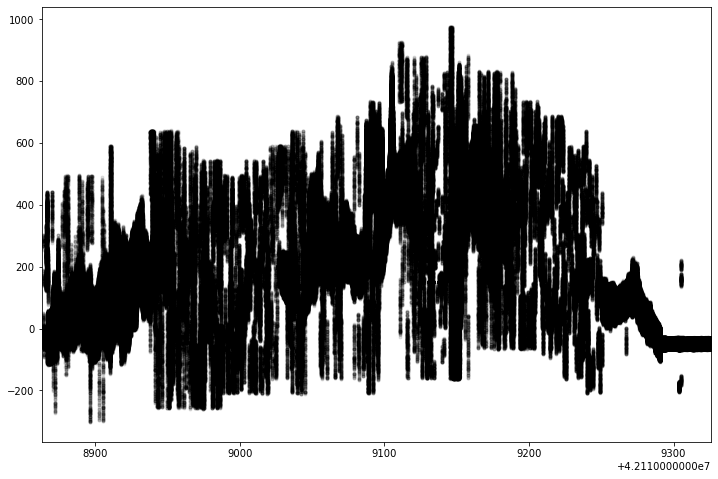

In [34]:
plt.figure(figsize=[12, 8])
plt.plot(df1.delta_time, df1.height, 'k.', 0.01, alpha=0.1)
plt.xlim(df1.delta_time.min(), df1.delta_time.max());

Note that the heights provided in h5 files are referenced to the ellipsoid. Orthometric heights can be retrieved directly using the geoid data supplied in ATL03 files (height_ortho = df.height - df.geoid_z), or your preferred method (pyproj, etc...).